In [15]:
import torch 
import sys, os

root_path = os.path.abspath(os.path.join(os.getcwd(), ".."))
if root_path not in sys.path:
    sys.path.append(root_path)

from src.data.load_data import * 
from src.model.restnet import * 
from src.testing_utils.evaluate_model import * 
from src.testing_utils.evaluate_plots import * 
from src.training.train_loop import *


## Load Data 

In [2]:
train_loader, val_loader, class_names, num_classes, (mean, std) = get_oxford_pet_loaders(
    data_dir="./data",
    batch_size=32,
    val_split=0.2,
    num_workers=2,
    seed=42,
    mode="binary",
    img_size=224,
    robust=False,
    stats_cache_path="./data/pet_stats.json",
    use_cached_if_available=True)

print("mean:", mean, "std:", std)

100%|██████████| 792M/792M [00:30<00:00, 26.2MB/s]
100%|██████████| 19.2M/19.2M [00:01<00:00, 10.7MB/s]


mean: [0.48293063044548035, 0.44492557644844055, 0.3957090973854065] std: [0.2592383325099945, 0.25327032804489136, 0.2598187029361725]


In [3]:
images, labels = next(iter(train_loader))
print(f"Batch shape: {images.shape}")
print(f"Labels shape: {labels.shape}")

Batch shape: torch.Size([32, 3, 224, 224])
Labels shape: torch.Size([32])


# Model and Training 

In [ ]:
import torch.optim as optim

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = ResNet(num_classes=2, blocks_per_stage=(3,4,23,3))
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=1e-3,betas=(0.9, 0.999),weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)


results = {}
epochs = 30
for i in range(epochs):
    print(f"Epoch {i+1}/{epochs}")
    metrics = train_epoch_classification(train_loader, model, optimizer, criterion,
                                         device=device, amp=True, desc="Train", scheduler=scheduler, pos_label=1)

    results[f'Epoca {i+1}'] = metrics

Epoch 1/30
Train - loss: 0.7246 | acc: 66.41% | F1: 79.47% (P: 67.85%, R: 95.89%)
Epoch 2/30
Train - loss: 0.6543 | acc: 66.95% | F1: 79.67% (P: 68.33%, R: 95.54%)
Epoch 3/30
Train - loss: 0.6314 | acc: 67.19% | F1: 79.94% (P: 68.26%, R: 96.44%)
Epoch 4/30
Train - loss: 0.6277 | acc: 67.36% | F1: 80.11% (P: 68.25%, R: 96.94%)
Epoch 5/30
Train - loss: 0.6225 | acc: 67.56% | F1: 80.08% (P: 68.60%, R: 96.19%)
Epoch 6/30
Train - loss: 0.6147 | acc: 67.53% | F1: 79.93% (P: 68.79%, R: 95.39%)
Epoch 7/30
Train - loss: 0.6113 | acc: 68.61% | F1: 80.45% (P: 69.63%, R: 95.24%)
Epoch 8/30
Train - loss: 0.5958 | acc: 68.72% | F1: 80.25% (P: 70.15%, R: 93.74%)
Epoch 9/30
Train - loss: 0.5904 | acc: 69.06% | F1: 80.40% (P: 70.45%, R: 93.64%)
Epoch 10/30
Train - loss: 0.5866 | acc: 69.40% | F1: 80.43% (P: 70.99%, R: 92.79%)
Epoch 11/30
Train - loss: 0.5738 | acc: 69.87% | F1: 80.28% (P: 72.15%, R: 90.48%)
Epoch 12/30
Train - loss: 0.5573 | acc: 70.92% | F1: 80.70% (P: 73.36%, R: 89.68%)
Epoch 13/30
T

## Parameters of the model 

In [11]:

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parámetros: {total_params:,}")
print(f"Parámetros entrenables: {trainable_params:,}")

Total parámetros: 42,504,258
Parámetros entrenables: 42,504,258


## Evaluate model 

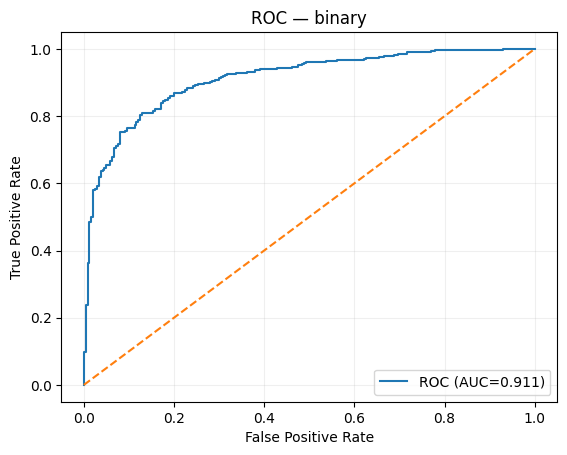

Val Loss: 0.4084  |  ROC-AUC: 0.9108

Classification report
              precision    recall  f1-score   support

           0     0.6840    0.8750    0.7678       240
           1     0.9301    0.8044    0.8627       496

    accuracy                         0.8274       736
   macro avg     0.8071    0.8397    0.8153       736
weighted avg     0.8498    0.8274    0.8318       736



In [9]:
metrics = evaluate_model(model, val_loader, criterion, device=device, multiclass=False, plot=True)

In [10]:
torch.save(model.state_dict(), "ResNet101.pth")

## Show Filters RGB aprox 

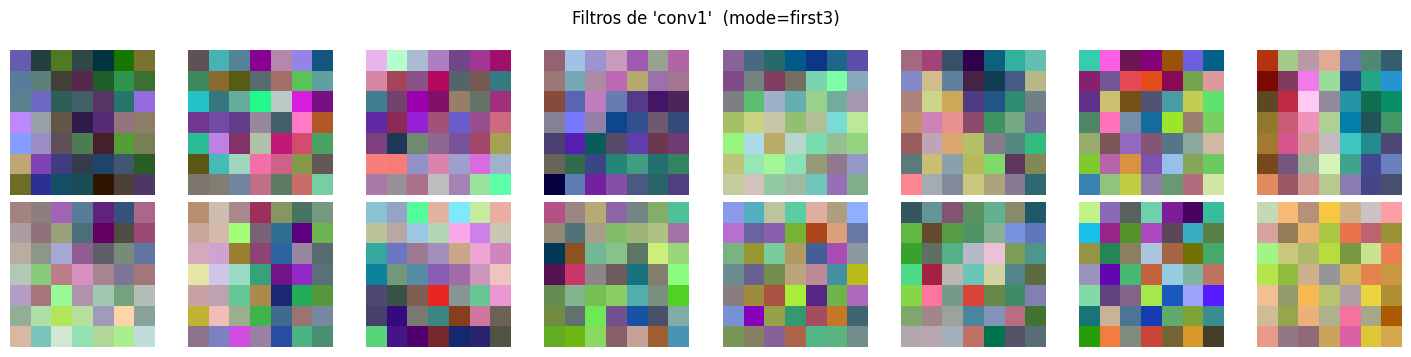

In [ ]:

show_layer_filters(model, "conv1" , max_filters=16 , mode="first3")

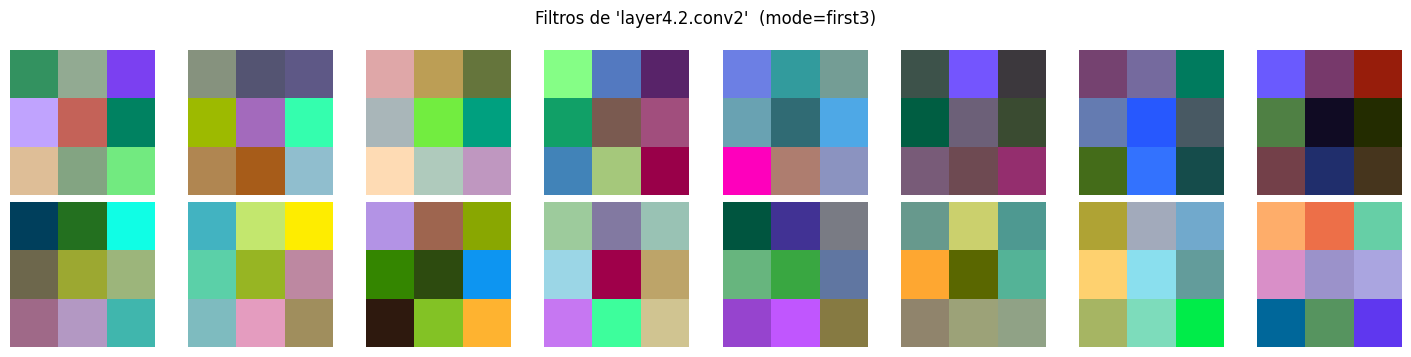

In [35]:
show_layer_filters(model, "layer4.2.conv2" , max_filters=16, mode="first3")

## Show Features Maps 

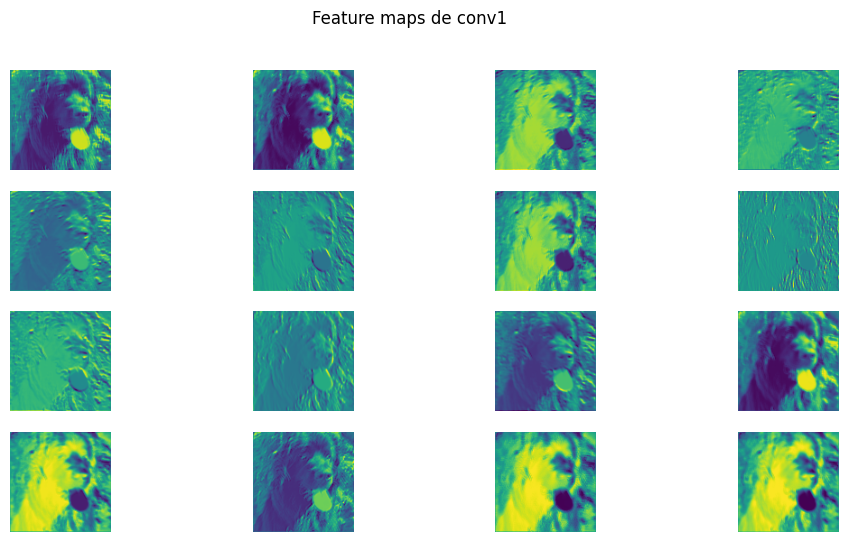

In [ ]:

xb, _ = next(iter(val_loader))
show_feature_maps(model, "conv1", xb[0].unsqueeze(0), device)

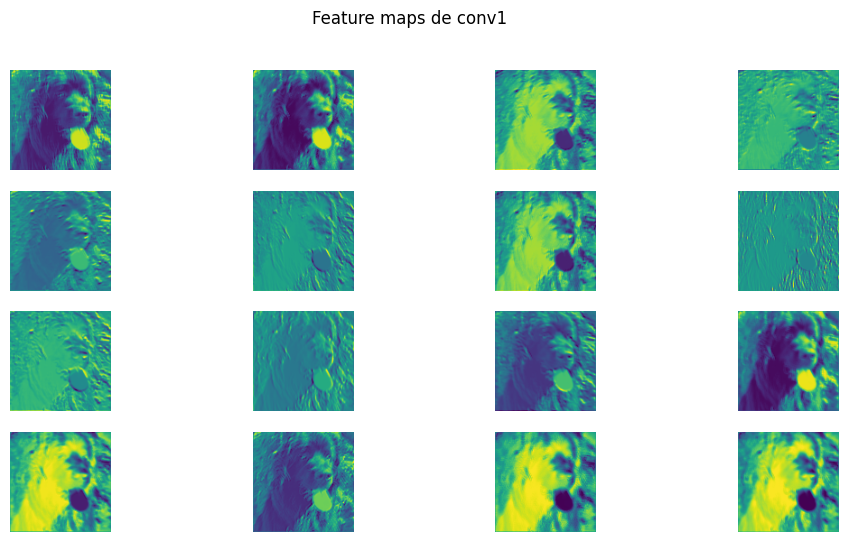

In [21]:
xb, _ = next(iter(val_loader))
show_feature_maps(model, "layer2.0.conv2", xb[0].unsqueeze(0), device)

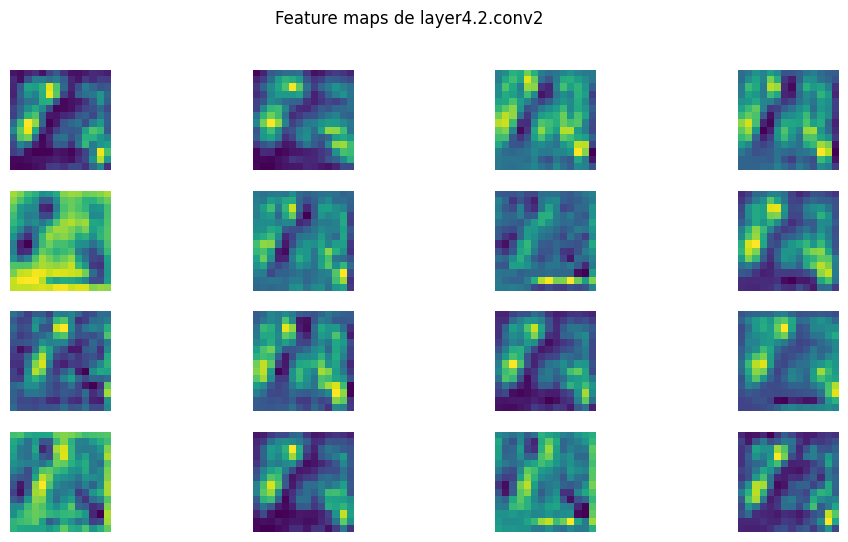

In [18]:

xb, _ = next(iter(val_loader))
show_feature_maps(model, "layer4.2.conv2", xb[0].unsqueeze(0), device)

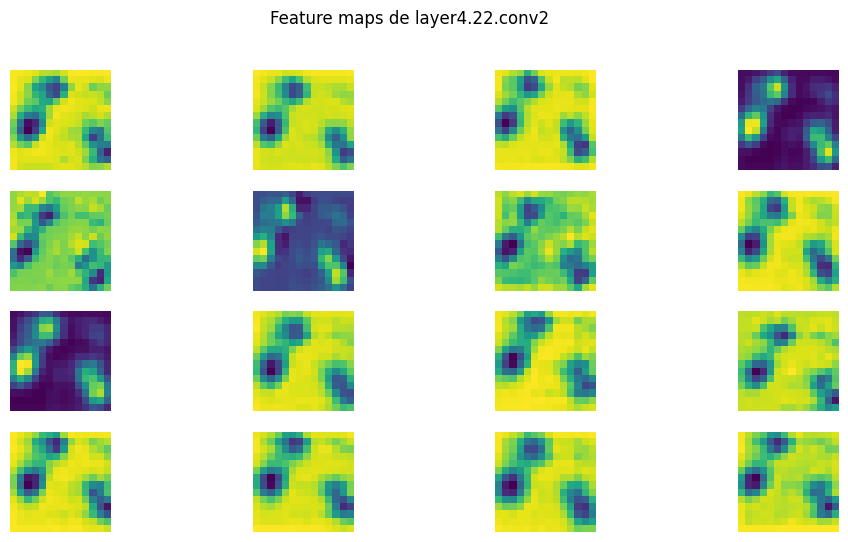

In [20]:
xb, _ = next(iter(val_loader))
show_feature_maps(model, "layer4.22.conv2", xb[0].unsqueeze(0), device)

## Show Activation Histogra 

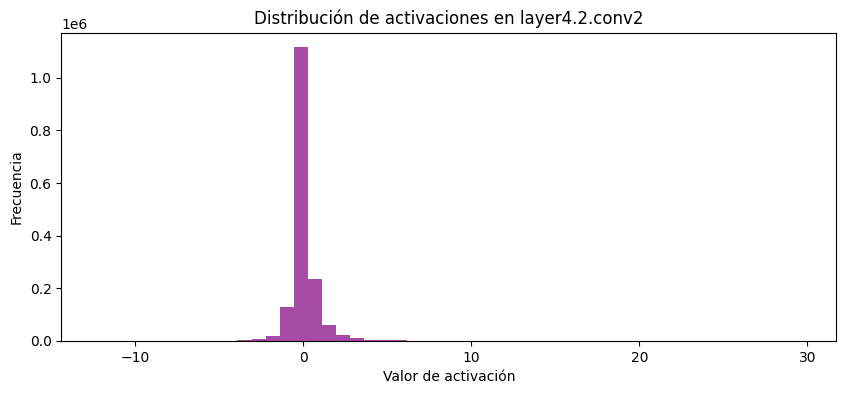

In [ ]:

plot_fc_activations(model, val_loader)

## Visualize predictions 

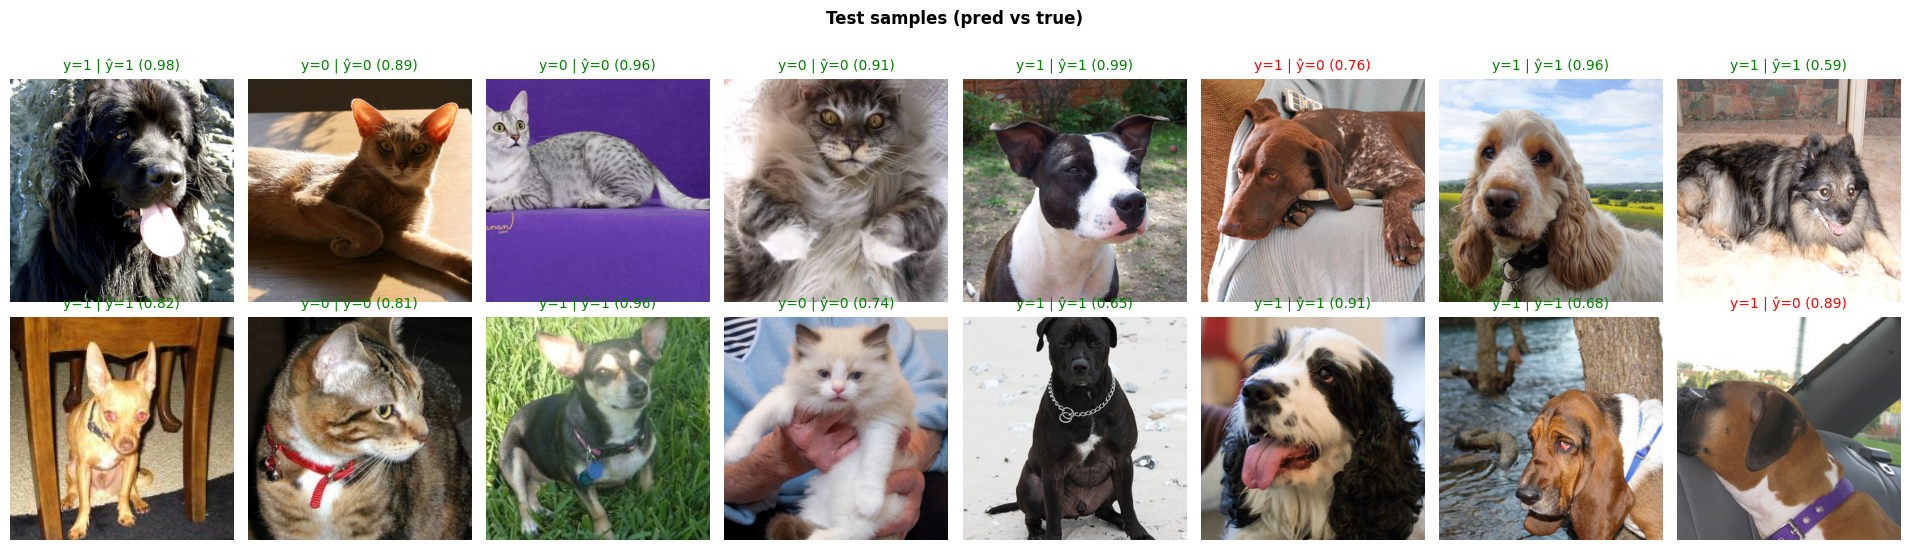

In [28]:
visualize_test_predictions(model, val_loader, device=device, n=16,only_errors=False)

## Pablo Reyes 